# [**Workflows for atomistic simulations**](http://potentials.rub.de/) 

## **Day 3 - Validation of various potentials**


### **Exercise 1: Validation of generated potentials using pyiron based workflows**

Before the excercise, you should:

* Have run the notebooks from day 1 and day2
* Be familiar with working with pyiron and the basics of potential fitting

The aim of this exercise is to make you familiar with:

* Potential validation techniques

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd

In [2]:
from pyiron import Project

In [79]:
pr = Project("validation")

In [80]:
# The list of potentials to iterate over

# The good potentials already added to the pyiron database
potential_list = ['Cu-ace', 'Cu-runner']
# The potentials that were fit yesterday



In [81]:
# Do Murnaghan, ElasticMatrix job, vac formation energy, binding energy, surface energies, comparison with dataset forces, energies

In [82]:
def clean_project_name(name):
    return name.replace("-", "_")

The job murn_job was saved and received the ID: 119
The job strain_0_9 was saved and received the ID: 120
The job strain_0_92 was saved and received the ID: 121
The job strain_0_94 was saved and received the ID: 122
The job strain_0_96 was saved and received the ID: 123
The job strain_0_98 was saved and received the ID: 124
The job strain_1_0 was saved and received the ID: 125
The job strain_1_02 was saved and received the ID: 126
The job strain_1_04 was saved and received the ID: 127
The job strain_1_06 was saved and received the ID: 128
The job strain_1_08 was saved and received the ID: 129
The job strain_1_1 was saved and received the ID: 130
job_id:  120 finished
job_id:  121 finished
job_id:  122 finished
job_id:  123 finished
job_id:  124 finished
job_id:  125 finished
job_id:  126 finished
job_id:  127 finished
job_id:  128 finished
job_id:  129 finished
job_id:  130 finished


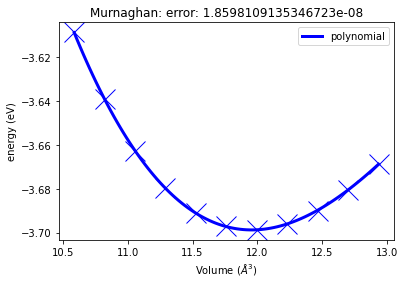

The job murn_job was saved and received the ID: 131
The job strain_0_9 was saved and received the ID: 132
The job strain_0_92 was saved and received the ID: 133
The job strain_0_94 was saved and received the ID: 134
The job strain_0_96 was saved and received the ID: 135
The job strain_0_98 was saved and received the ID: 136
The job strain_1_0 was saved and received the ID: 137
The job strain_1_02 was saved and received the ID: 138
The job strain_1_04 was saved and received the ID: 139
The job strain_1_06 was saved and received the ID: 140
The job strain_1_08 was saved and received the ID: 141
The job strain_1_1 was saved and received the ID: 142
job_id:  132 finished
job_id:  133 finished
job_id:  134 finished
job_id:  135 finished
job_id:  136 finished
job_id:  137 finished
job_id:  138 finished
job_id:  139 finished
job_id:  140 finished
job_id:  141 finished
job_id:  142 finished


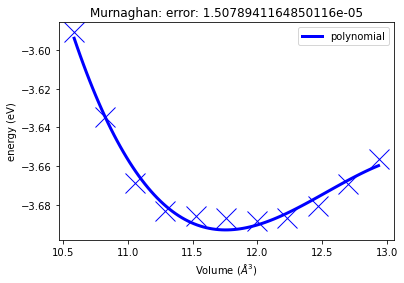

CPU times: user 35.7 s, sys: 29.5 s, total: 1min 5s
Wall time: 49.6 s


In [83]:
%%time
for pot in potential_list:
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(pot)
    job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, "ref_job")
    job_ref.structure = pr_pot.create_ase_bulk("Cu")
    job_ref.potential = pot
    job_ref.calc_minimize()
    murn_job = job_ref.create_job(pr_pot.job_type.Murnaghan, "murn_job")
    murn_job.run()
    murn_job.plot()

In [84]:
murn_job["output/equilibrium_energy"]

-3.6930468810926627

In [85]:
def get_only_murn(job_table):
    return job_table.hamilton == "Murnaghan"

def get_eq_vol(job_path):
    return job_path["output/equilibrium_volume"]

def get_eq_lp(job_path):
    return np.linalg.norm(job_path["output/structure/cell/cell"][0]) * np.sqrt(2)

def get_eq_bm(job_path):
    return job_path["output/equilibrium_bulk_modulus"]

def get_potential(job_path):
    return job_path["ref_job/input/potential/Name"]

def get_eq_energy(job_path):
    return job_path["output/equilibrium_energy"]

def get_n_atoms(job_path):
    return len(job_path["output/structure/positions"])

In [86]:
%%time
table = pr.create_table("table_murn", delete_existing_job=True)
table.db_filter_function = get_only_murn
table.add["potential"] = get_potential
table.add["a"] = get_eq_lp
table.add["eq_vol"] = get_eq_vol
table.add["eq_bm"] = get_eq_bm
table.add["eq_energy"] = get_eq_energy
table.add["n_atoms"] = get_n_atoms
table.run()
data_murn = table.get_dataframe()
data_murn

100%|██████████| 2/2 [00:00<00:00, 23.03it/s]

The job table_murn was saved and received the ID: 143
CPU times: user 234 ms, sys: 141 ms, total: 375 ms
Wall time: 379 ms


,job_id,potential,a,eq_vol,eq_bm,eq_energy,n_atoms
0,119,Cu-ace,3.629863,11.956678,146.220099,-3.698781,1
1,131,Cu-runner,3.609436,11.755954,181.669418,-3.693047,1


In [87]:
%%time
for pot in data_murn.potential.to_list():
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(pot)
    print(pot)
    job_id = int(data_murn[data_murn.potential==pot].job_id)
    job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, "ref_job")
    job_ref.structure = pr_pot.inspect(job_id)["output/structure"].to_object()
    job_ref.potential = pot
    job_ref.calc_minimize()
    elastic_job = job_ref.create_job(pr_pot.job_type.ElasticMatrixJob, "elastic_job")
    elastic_job.input["eps_range"] = 0.05
    elastic_job.run()

Cu-ace
The job elastic_job was saved and received the ID: 144
The job s_e_0 was saved and received the ID: 145
The job s_01_e_m0_05000 was saved and received the ID: 146
The job s_01_e_m0_02500 was saved and received the ID: 147
The job s_01_e_0_02500 was saved and received the ID: 148
The job s_01_e_0_05000 was saved and received the ID: 149
The job s_08_e_m0_05000 was saved and received the ID: 150
The job s_08_e_m0_02500 was saved and received the ID: 151
The job s_08_e_0_02500 was saved and received the ID: 152
The job s_08_e_0_05000 was saved and received the ID: 153
The job s_23_e_m0_05000 was saved and received the ID: 154
The job s_23_e_m0_02500 was saved and received the ID: 155
The job s_23_e_0_02500 was saved and received the ID: 156
The job s_23_e_0_05000 was saved and received the ID: 157
Cu-runner
The job elastic_job was saved and received the ID: 158
The job s_e_0 was saved and received the ID: 159
The job s_01_e_m0_05000 was saved and received the ID: 160
The job s_01_e

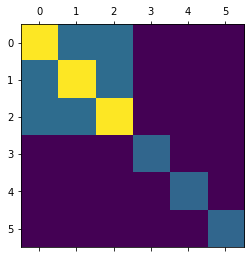

In [88]:
plt.matshow(elastic_job["output/elasticmatrix"]["C"]);

In [89]:
elastic_job["output/elasticmatrix"]["C"].flatten()

array([285.91475361, 100.57996064, 100.57996064,   0.        ,
         0.        ,   0.        , 100.57996064, 285.91475361,
       100.57996064,   0.        ,   0.        ,   0.        ,
       100.57996064, 100.57996064, 285.91475361,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  94.7567399 ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        94.7567399 ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  94.7567399 ])

In [91]:
def filter_elastic(job_table):
    return (job_table.hamilton == "ElasticMatrixJob") & (job_table.status == "finished")

def get_c11(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 0]

def get_c12(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 1]

def get_c44(job_path):
    return job_path["output/elasticmatrix"]["C"][3, 3]

In [92]:
%%time
table = pr.create_table("table_elastic", delete_existing_job=True)
table.db_filter_function = filter_elastic
table.add["potential"] = get_potential
table.add["C11"] = get_c11
table.add["C12"] = get_c12
table.add["C44"] = get_c44

table.run()
data_elastic = table.get_dataframe()
data_elastic

 50%|█████     | 1/2 [00:00<00:00,  6.89it/s]

The job table_elastic was saved and received the ID: 172


100%|██████████| 2/2 [00:00<00:00,  7.06it/s]


CPU times: user 375 ms, sys: 62.5 ms, total: 438 ms
Wall time: 508 ms


,job_id,potential,C11,C12,C44
0,144,Cu-ace,182.054447,132.575877,81.049351
1,158,Cu-runner,285.914754,100.579961,94.756740


In [93]:
from structdbrest import StructDBLightRester
rest = StructDBLightRester(token="workshop2021")
fhi_calc = rest.query_calculator_types("FHI%aims%")[0]
dft_elast_prop = rest.query_properties(rest.PropertyTypes.ELASTIC_MATRIX, composition="Cu-%", strukturbericht="A1", 
                      calculator_name=fhi_calc.NAME)[0]

dft_phon_prop = rest.query_properties(rest.PropertyTypes.PHONONS, composition="Cu-%", strukturbericht="A1", 
                      calculator_name=fhi_calc.NAME)[0]

Querying...done
Response successful, size = 7.20 kB, time = 0.12 s
1  entries received
Querying...done
Response successful, size = 37.78 kB, time = 0.39 s
1  entries received
Querying...done
Response successful, size = 22.50 kB, time = 0.20 s
1  entries received


In [94]:
C_dft = dft_elast_prop.value["C"]
print("DFT C11={:.1f} GPa".format(C_dft[0][0]))
print("DFT C12={:.1f} GPa".format(C_dft[0][1]))
print("DFT C44={:.1f} GPa".format(C_dft[3][3]))

DFT C11=176.9 GPa
DFT C12=131.7 GPa
DFT C44=82.5 GPa


In [95]:
%%time

surface_type_list = ["fcc111", "fcc110", "fcc100"]

for i, pot in enumerate(data_murn.potential.to_list()):
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(group_name)
    a = data_murn.a.to_list()[i]
    for surface_type in surface_type_list:
        surface = pr.create_surface("Cu", surface_type=surface_type, size=(8, 8, 8), a=a, orthogonal=True, vacuum=12)
        job_lammps = pr_pot.create_job(pr_pot.job_type.Lammps, "surf_{}".format(surface_type))
        job_lammps.structure = surface
        job_lammps.potential = pot
        job_lammps.calc_minimize()
        job_lammps.run()

The job surf_fcc111 was saved and received the ID: 173
The job surf_fcc110 was saved and received the ID: 174
The job surf_fcc100 was saved and received the ID: 175
The job surf_fcc111 was saved and received the ID: 176


2021-03-08 17:14:27,818 - pyiron_log - WARNING - Job aborted
2021-03-08 17:14:27,820 - pyiron_log - WARNING - LAMMPS (10 Feb 2021)
Reading data file ...
  orthogonal box = (0.0000000 0.0000000 0.0000000) to (20.418051 17.682551 26.587360)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  512 atoms
  read_data CPU = 0.004 seconds

*******************************************************************************

WELCOME TO n²p², A SOFTWARE PACKAGE FOR NEURAL NETWORK POTENTIALS!
------------------------------------------------------------------

n²p² version      : 553e609
------------------------------------------------------------
Git branch        : HEAD
Git revision      : 553e6097553afe442843cc45bce5c974b1ec2f92
Compile date/time : Feb 15 2021 12:43:18
------------------------------------------------------------

Please cite the following papers when publishing results obtained with n²p²:
-------------------------------------------------------------------------------
 * General c

RuntimeError: Job aborted

In [19]:
# pot = "Cu-runner"
# group_name = clean_project_name(pot)
# pr_pot = pr.create_group(group_name)
# a = data_murn.a.to_list()[i]
# for surface_type in surface_type_list:
#     surface = pr.create_surface("Cu", surface_type=surface_type, size=(8, 8, 8), a=a, orthogonal=True, vacuum=12)
#     job_lammps = pr_pot.create_job(pr_pot.job_type.Lammps, "surf_{}".format(surface_type))
#     job_lammps.structure = surface
#     job_lammps.potential = pot
#     job_lammps.calc_minimize()
#     job_lammps.run()

In [99]:
def is_a_surface(job_table):
    return (job_table.hamilton == "Lammps") & (job_table.job.str.contains("fcc")) & (job_table.status == "finished")

def get_potential_lammps_job(job_path):
    return job_path["input/potential/Name"]

def get_surface_type(job_path):
    surf_list =  ["fcc111", "fcc110", "fcc100"]
    conditions = [val in job_path.job_name for val in surf_list]
    return surf_list[np.where(conditions)[0].tolist()[0]]

def get_area(job_path):
    cell = job_path["output/structure/cell/cell"]
    return np.linalg.norm(np.cross(cell[0], cell[1]))

In [100]:
%%time
table = pr.create_table("table_surface", delete_existing_job=True)
table.db_filter_function = is_a_surface
table.add["potential"] = get_potential_lammps_job
table.add["surface_type"] = get_surface_type
table.add["surface_area"] = get_area
table.add.get_total_number_of_atoms

table.add.get_energy_tot
table.run()
data_surf = table.get_dataframe()
data_surf

100%|██████████| 3/3 [00:00<00:00, 35.51it/s]

The job table_surface was saved and received the ID: 177
CPU times: user 219 ms, sys: 109 ms, total: 328 ms
Wall time: 331 ms


,Number_of_atoms,job_id,energy_tot,potential,surface_type,surface_area
0,512,173,-1834.286336,Cu-ace,fcc111,365.141308
1,512,174,-1775.620101,Cu-ace,fcc110,596.273259
2,512,175,-1814.469585,Cu-ace,fcc100,421.628865


In [101]:
data_merged = pd.merge(data_surf, data_murn, on="potential")
data_merged

,Number_of_atoms,job_id_x,energy_tot,potential,surface_type,surface_area,job_id_y,a,eq_vol,eq_bm,eq_energy,n_atoms
0,512,173,-1834.286336,Cu-ace,fcc111,365.141308,119,3.629863,11.956678,146.220099,-3.698781,1
1,512,174,-1775.620101,Cu-ace,fcc110,596.273259,119,3.629863,11.956678,146.220099,-3.698781,1
2,512,175,-1814.469585,Cu-ace,fcc100,421.628865,119,3.629863,11.956678,146.220099,-3.698781,1


In [102]:
data_merged["surface_energy"] = data_merged.energy_tot - (data_merged.eq_energy * data_merged.Number_of_atoms)

In [103]:
data_merged["surface_energy_in_mJ_per_sq_m"] = data_merged.surface_energy / data_merged.surface_area / 2 * 16.0219 * 1e3

In [104]:
data_merged

,Number_of_atoms,job_id_x,energy_tot,potential,surface_type,surface_area,job_id_y,a,eq_vol,eq_bm,eq_energy,n_atoms,surface_energy,surface_energy_in_mJ_per_sq_m
0,512,173,-1834.286336,Cu-ace,fcc111,365.141308,119,3.629863,11.956678,146.220099,-3.698781,1,59.489333,1305.155196
1,512,174,-1775.620101,Cu-ace,fcc110,596.273259,119,3.629863,11.956678,146.220099,-3.698781,1,118.155568,1587.423774
2,512,175,-1814.469585,Cu-ace,fcc100,421.628865,119,3.629863,11.956678,146.220099,-3.698781,1,79.306085,1506.815901


## Finite temperature thermodynamics (Harmonic approximation)

In [28]:
# phonon DOS more analysis (comparison with some datasets)

In [105]:
%%time
for pot in data_murn.potential.to_list():
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(group_name)
    job_id = int(data_murn[data_murn.potential==pot].job_id)
    job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, "ref_job")
    job_ref.structure = pr_pot.inspect(job_id)["output/structure"].to_object()
    job_ref.potential = pot
    job_ref.calc_static()
    phonopy_job = job_ref.create_job(pr_pot.job_type.PhonopyJob, "phonopy_job")
    phonopy_job.run()

The job phonopy_job was saved and received the ID: 178
The job ref_job_0 was saved and received the ID: 179
The job phonopy_job was saved and received the ID: 180
The job ref_job_0 was saved and received the ID: 181
CPU times: user 9.8 s, sys: 5.7 s, total: 15.5 s
Wall time: 10.1 s


In [106]:
pr

{'groups': ['Cu-ace', 'Cu-runner', 'Cu_ace', 'Cu_runner'], 'nodes': ['table_murn', 'table_elastic', 'table_surface']}

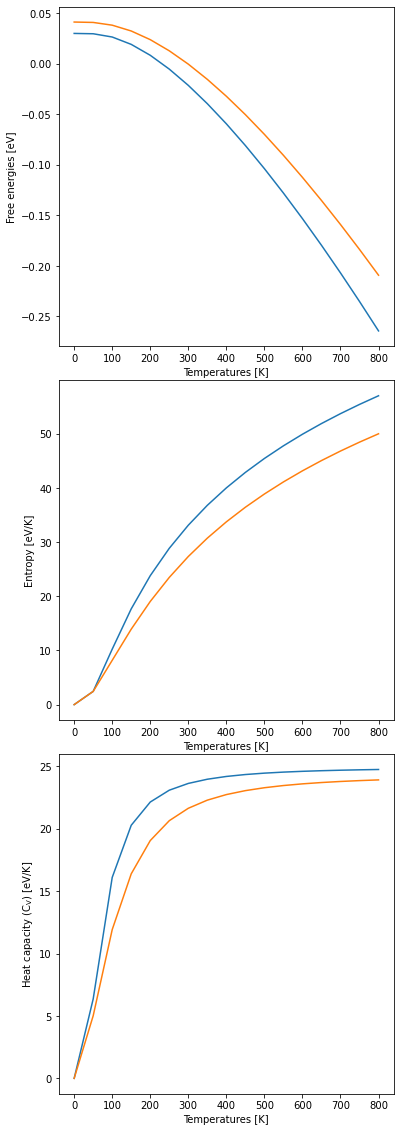

In [107]:
fig, ax_list = plt.subplots(ncols=1, nrows=3, sharex="row")
#fig.set_figwidth(20)
fig.set_figheight(20)


for i, pot in enumerate(potential_list):
    group_name = clean_project_name(pot)
    phonopy_job = pr[group_name+"/phonopy_job"]
    thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
    
    ax = ax_list[0]
    ax.plot(thermo.temperatures, thermo.free_energies)
    ax.set_xlabel("Temperatures [K]")
    ax.set_ylabel("Free energies [eV]")
    
    ax = ax_list[1]
    ax.plot(thermo.temperatures, thermo.entropy)
    ax.set_xlabel("Temperatures [K]")
    ax.set_ylabel("Entropy [eV/K]")
    
    ax = ax_list[2]
    ax.plot(thermo.temperatures, thermo.cv)
    ax.set_xlabel("Temperatures [K]")
    ax.set_ylabel("Heat capacity (C$_\mathrm{V}$) [eV/K]")
    
fig.subplots_adjust(hspace=0.1);    

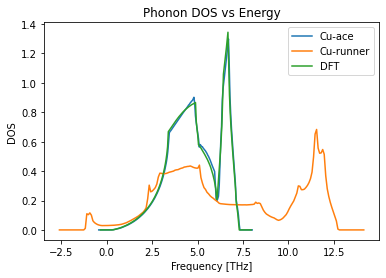

In [108]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex="row")

for i, pot in enumerate(potential_list):
    group_name = clean_project_name(pot)
    phonopy_job = pr[group_name+"/phonopy_job"]
    thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
    phonopy_job.plot_dos(label=pot, ax=ax)
ax.plot(dft_phon_prop.value["dos_energies"],  dft_phon_prop.value["dos_total"], label="DFT")
ax.legend()

## **Validating against datasets**

In [109]:
data_pr = Project("../datasets/imported_datasets")
data_pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,73,finished,None,df1_A1_A2_A3_EV_elast_phon,/df1_A1_A2_A3_EV_elast_phon,/home/surendralal/,notebooks/pyiron_potentialfit/datasets/imported_datasets/Cu_database/,2021-02-08 10:33:52.341472,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None
1,74,finished,None,df3_10k,/df3_10k,/home/surendralal/,notebooks/pyiron_potentialfit/datasets/imported_datasets/Cu_database/,2021-02-08 10:33:53.993230,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None
2,75,finished,None,df2_1k,/df2_1k,/home/surendralal/,notebooks/pyiron_potentialfit/datasets/imported_datasets/Cu_database/,2021-02-08 10:33:54.435308,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None


In [110]:
container = data_pr.load("df1_A1_A2_A3_EV_elast_phon")


In [111]:
training_dataset = container.to_pandas()

In [112]:
training_dataset

,name,atoms,energy,forces,number_of_atoms
0,A1:FHI-aims/PBE/tight:elastic:s_e_0,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.699843,"[[0.0, 0.0, 0.0]]",1.0
1,A1:FHI-aims/PBE/tight:murnaghan:strain_1_0,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.699841,"[[0.0, 0.0, 0.0]]",1.0
2,A1:FHI-aims/PBE/tight:phonon:supercell_phonon_0,"(Atom('Cu', [4.3368086899420173e-19, 0.007070999999999999, 0.007070999999999999], index=0), Atom('Cu', [3.3306690738754696e-16, 1.81563, 1.8156300000000005], index=1), Atom('Cu', [7.262518, 10.893...",-236.789603,"[[-1.13852957740976e-06, -0.0464638907314277, -0.0464636807741622], [-3.86335457040412e-06, 0.0124851330231607, 0.0124792943417333], [-1.94300535086066e-06, 6.63943441884098e-05, 6.92790474109119e...",64.0
3,A1:FHI-aims/PBE/tight:murnaghan:strain_1_02,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.697932,"[[0.0, 0.0, 0.0]]",1.0
4,A1:FHI-aims/PBE/tight:murnaghan:strain_0_98,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.697559,"[[0.0, 0.0, 0.0]]",1.0
...,...,...,...,...,...
100,A2:FHI-aims/PBE/tight:elastic:s_01_e_0_05000,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.573436,"[[0.0, 0.0, 0.0]]",1.0
101,A1:FHI-aims/PBE/tight:elastic:s_01_e_m0_05000,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.546222,"[[0.0, 0.0, 0.0]]",1.0
102,A3:FHI-aims/PBE/tight:elastic:s_01_e_m0_05000,"(Atom('Cu', [1.2150849, 0.70152958, 0.9998186400000001], index=0), Atom('Cu', [0.0, 1.40305917, 2.99945593], index=1))",-7.079448,"[[-3.5446112180968e-23, -1.13427558979097e-22, 0.0], [3.5446112180968e-23, 1.13427558979097e-22, 0.0]]",2.0
103,A2:FHI-aims/PBE/tight:elastic:s_01_e_m0_05000,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.513068,"[[0.0, 0.0, 0.0]]",1.0


In [113]:
structure_list, energy_list, force_list, num_atoms_list =  container.to_list()

energy_per_atom_list = np.array(energy_list) / np.array(num_atoms_list)


In [114]:
%%time
energy_pred_dict = dict()
force_pred_dict = dict()


for pot in potential_list:
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(pot)
    energy_pred_list = list()
    force_pred_list = list()
    
    stride = 10
    for i, struct in enumerate(structure_list[::stride]):
        job = pr_pot.create_job(pr.job_type.Lammps, "lammps_struct_{}".format(i))
        job.potential = pot
        job.structure = struct
        job.calc_static()
        job.run()
        energy_pred_list.append(job["output/generic/energy_tot"][-1] / len(struct))
        force_pred_list.append(job["output/generic/forces"][-1])
    job_box = pr_pot.create_job(pr.job_type.Lammps, "lammps_box")
    job_box.potential = pot
    job_box.structure = pr_pot.create_atoms("Cu", scaled_positions=[[0.5, 0.5, 0.5]], cell=np.eye(3)*10, pbc=True)
    job_box.calc_static()
    job_box.run()
    # correct for energy of isolated atom
    if "runner" in pot:
        energy_pred_list = np.array(energy_pred_list)
    else:
        energy_pred_list = np.array(energy_pred_list) - job_box["output/generic/energy_tot"][-1]
        
    energy_pred_dict[pot] = energy_pred_list
    force_pred_dict[pot] = force_pred_list

The job lammps_struct_0 was saved and received the ID: 182
The job lammps_struct_1 was saved and received the ID: 183
The job lammps_struct_2 was saved and received the ID: 184
The job lammps_struct_3 was saved and received the ID: 185
The job lammps_struct_4 was saved and received the ID: 186
The job lammps_struct_5 was saved and received the ID: 187
The job lammps_struct_6 was saved and received the ID: 188
The job lammps_struct_7 was saved and received the ID: 189
The job lammps_struct_8 was saved and received the ID: 190
The job lammps_struct_9 was saved and received the ID: 191
The job lammps_struct_10 was saved and received the ID: 192
The job lammps_box was saved and received the ID: 193
The job lammps_struct_0 was saved and received the ID: 194
The job lammps_struct_1 was saved and received the ID: 195
The job lammps_struct_2 was saved and received the ID: 196
The job lammps_struct_3 was saved and received the ID: 197
The job lammps_struct_4 was saved and received the ID: 198
T

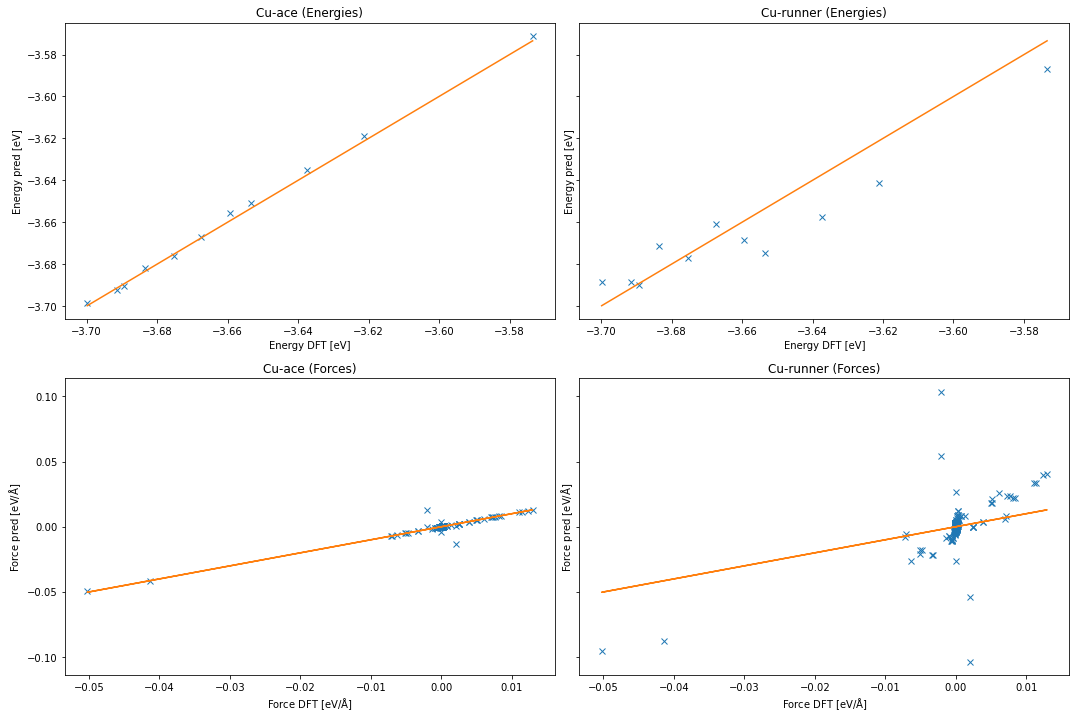

In [123]:
fig, ax_list = plt.subplots(ncols=len(potential_list), nrows=2, sharey="row", sharex="row")
fig.set_figwidth(18)
fig.set_figheight(12)

for i, (pot, energy_pred) in enumerate(energy_pred_dict.items()):
    
    ax = ax_list[0][i]
    ax.plot(energy_per_atom_list[::stride], energy_pred, "x")
    ax.plot(energy_per_atom_list[::stride], energy_per_atom_list[::stride])
    ax.set_title(pot + " (Energies)")
    ax.set_xlabel("Energy DFT [eV]")
    ax.set_ylabel("Energy pred [eV]")
    
    ax = ax_list[1][i]
    force_orig = np.hstack([f.flatten() for f in force_list[::stride]])
    force_pred = np.hstack([f.flatten() for f in force_pred_dict[pot]])
    
    ax.plot(force_orig, force_pred, "x")
    ax.plot(force_orig, force_orig)
    ax.set_xlabel("Force DFT [eV/$\mathrm{\AA}$]")
    ax.set_ylabel("Force pred [eV/$\mathrm{\AA}$]")
    ax.set_title(pot + " (Forces)")
    
fig.subplots_adjust(wspace=0.05, hspace=0.2)
# ax.set_ylim(x_lim)